# 다양체 학습 (Manifold Learning)

* 높은 차원의 데이터를 저차원으로 축소하는 방법

![manifold](https://scikit-learn.org/stable/_images/sphx_glr_plot_compare_methods_001.png)

* 고차원 데이터를 2차원 또는 3차원으로 축소해 시각화에 활용할 수 있음
* 차원 축소 과정에서 중요하지 않은 정보는 버려지고 중요한 정보만 남기 때문에 데이터 정제에 활용 가능

## 데이터 생성 및 시각화 함수

In [1]:
import multiprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(['seaborn-whitegrid'])
import seaborn as sns
import warnings

from sklearn.datasets import load_iris, load_wine, load_breast_cancer
from sklearn.datasets import load_boston, load_diabetes
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

from sklearn.pipeline import make_pipeline, Pipeline # 개체도가져온것
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

from sklearn import manifold
from sklearn import random_projection
from sklearn import datasets

In [2]:
# s_curve랑 color 데이터셋 받아옴 
s_curve, color = datasets.make_s_curve(1000, random_state=0)

In [3]:
# 숫자 데이터 X,y로받아옴
digits, labels = datasets.load_digits(return_X_y=True)
#희소행렬로 프로젝션함 
rand_proj = random_projection.SparseRandomProjection(n_components=3, random_state=0)
#digits 자료를 구성 3개짜리 희소행렬로 프로젝션한것을 fit한것
projected_digits = rand_proj.fit_transform(digits)



In [4]:
#X값의 min max로 scaling하는 함수 
def min_max_scale(x):
    min_value, max_value = np.min(x,0), np.max(x,0)
    x = (x - min_value) / (max_value - min_value)
    return x

In [5]:
#S_curve 그리는 함수 

def plot_s_curve(s_curve, color, position, projection):
    #s_curve값을 받으면 스케일링 
    s_curve = min_max_scale(s_curve)
    #projection이 3d이면 포지션값과 subplot의 프로젝션에 3d로표시하고 
    #scatter값을 주어서 그림 
    if projection == '3d':
        ax = plt.subplot(position, projection=projection)
        ax.scatter(s_curve[:, 0], s_curve[:, 1], s_curve[:,2], c=color, cmap=plt.cm.Spectral)
        #그림 초기화 좌표 
        ax.view_init(4, -72)
    elif projection == '2d':
        ax = plt.subplot(position)
        ax.scatter(s_curve[:, 0], s_curve[:, 1], c=color, cmap=plt.cm.Spectral)
                           

In [6]:
def plot_digits(digits, labels, position, projection):
    digits = min_max_scale(digits)
    if projection == '3d':
        ax = plt.subplot(position, projection=projection)
        for i in range(digits.shape[0]):
            ax.text(digits[i, 0], digits[i, 1], digits[i, 2],
                    str(labels[i]), color=plt.cm.Set1(labels[i] / 10), 
                    fontdict={'weight':'bold', 'size':9})
        ax.view_init(4, -72)
    elif projection == '2d':
        ax = plt.subplot(position)
        for i in range(digits.shape[0]):
            ax.text(digits[i, 0], digits[i, 1],
                    str(labels[i]), color=plt.cm.Set1(labels[i] / 10),
                    fontdict={'weight':'bold', 'size':9})

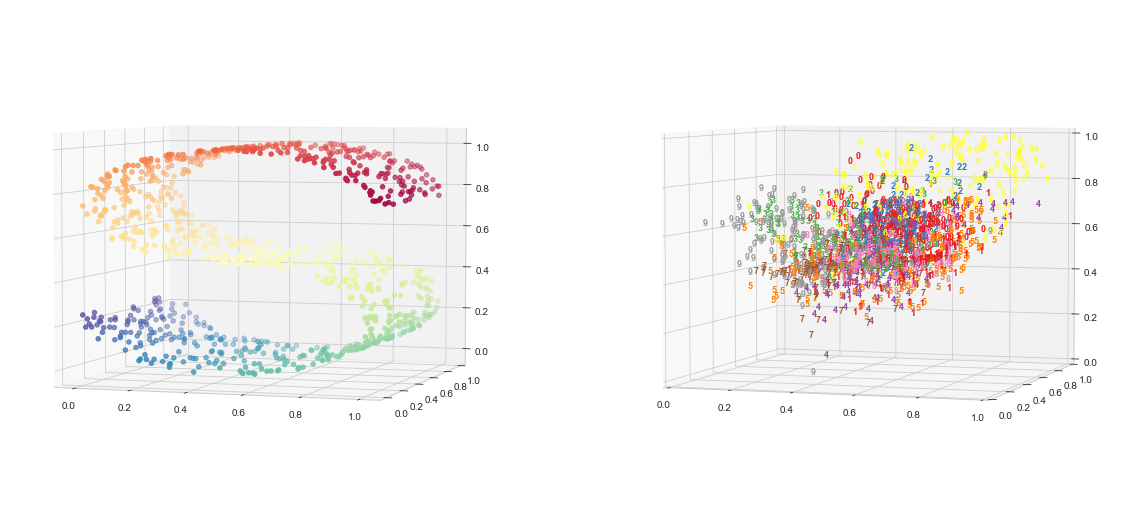

In [7]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve, color, 121,'3d')
plot_digits(projected_digits, labels, 122, '3d')

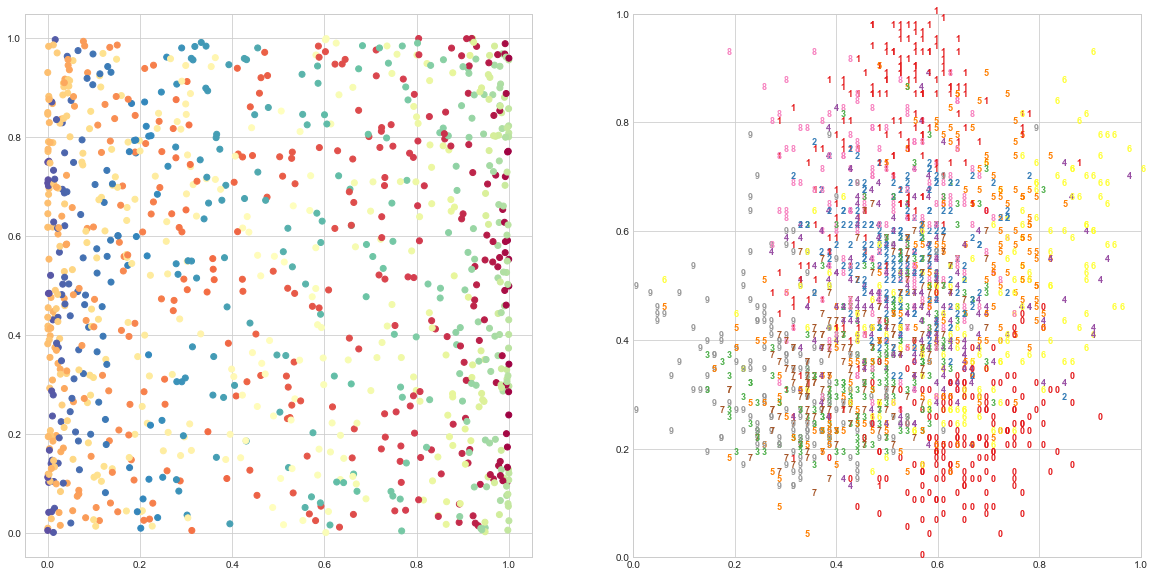

In [8]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve, color, 121,'2d')

plot_digits(projected_digits, labels, 122, '2d')


## Locally Linear Embedding (LLE)

* 국소 이웃 거리를 보존하는 저차원 임베딩을 찾음

In [9]:
s_curve_lle = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='standard',
                                              random_state=0).fit_transform(s_curve)
digits_lle = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=3, method='standard',
                                              random_state=0).fit_transform(digits)

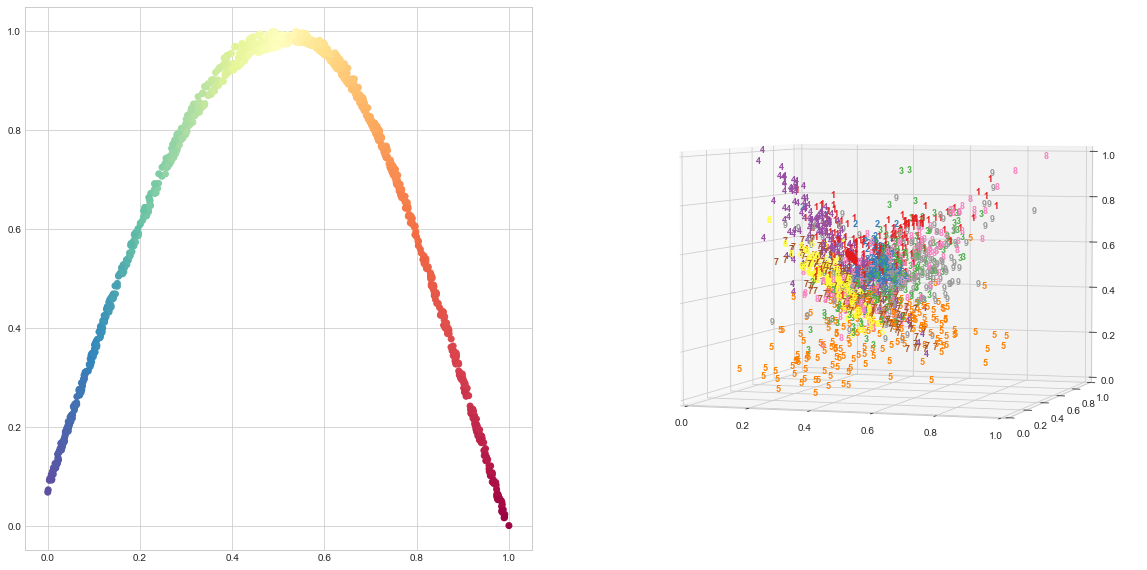

In [10]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve_lle, color, 121, '2d')
plot_digits(digits_lle, labels, 122, '3d')

## Local Tangent Space Alignment (LTSA)

* 탄젠트 공간을 통해 각 이웃의 국소 성질을 특성화
* 국소 탄젠트 공간을 정렬

In [11]:
s_curve_ltsa = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='ltsa',
                                              random_state=0).fit_transform(s_curve)
digits_ltsa = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=3, method='ltsa',
                                              random_state=0).fit_transform(digits)

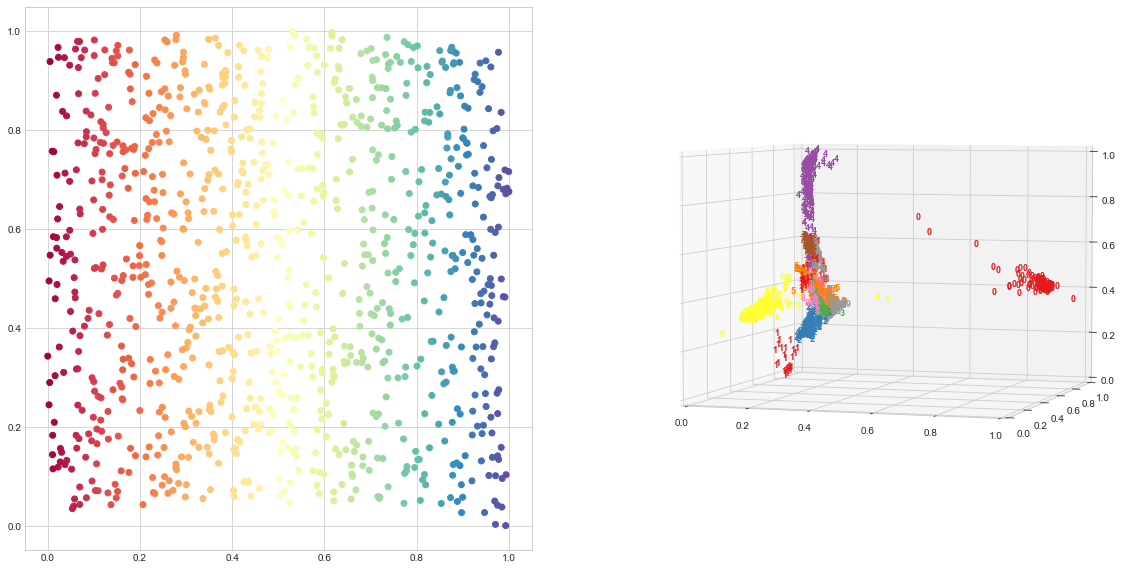

In [12]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve_ltsa, color, 121, '2d')
plot_digits(digits_ltsa, labels, 122, '3d')

## Hessian Eigenmapping

* LLE의 문제를 해결한 다른 방법
* 국소 선형 구조를 복원하기 위해 각 이웃에서 hessian 기반의 이차 형태를 중심으로 회전

In [13]:
s_curve_hlle = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='hessian',
                                              random_state=0).fit_transform(s_curve)
digits_hlle = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=3, method='hessian',
                                              random_state=0).fit_transform(digits)

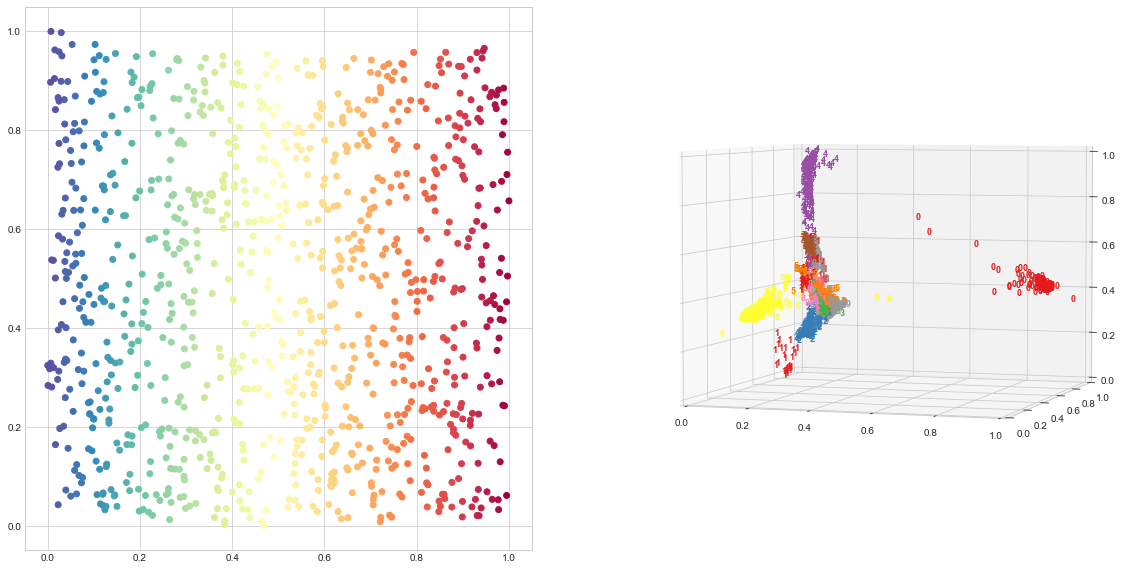

In [14]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve_hlle, color, 121, '2d')
plot_digits(digits_hlle, labels, 122, '3d')

## Modified Locally Linear Embedding

* 각 이웃에 여러 가중치 벡터를 사용
* n_neighbors > n_components를 만족해야 함

In [15]:
s_curve_mlle = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=2, method='modified',
                                              random_state=0).fit_transform(s_curve)
digits_mlle = manifold.LocallyLinearEmbedding(n_neighbors=30, n_components=3, method='modified',
                                              random_state=0).fit_transform(digits)

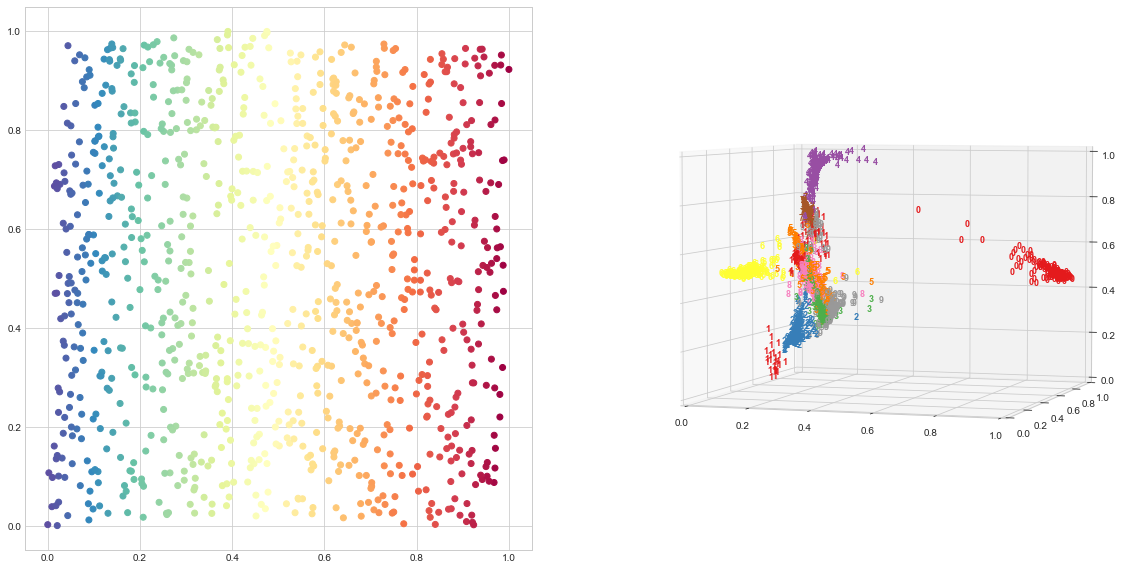

In [16]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve_mlle, color, 121, '2d')
plot_digits(digits_mlle, labels, 122, '3d')

## Isomap

* 초기의 다양체 학습 알고리즘
* MDS와 커널 PCA의 확장으로 볼 수 있음
* 모든 점들 사이의 측지 거리를 유지하는 저차원 임베딩을 찾음

In [17]:
s_curve_isomap = manifold.Isomap(n_neighbors=30, n_components=2).fit_transform(s_curve)
digits_isomap = manifold.Isomap(n_neighbors=30, n_components=3).fit_transform(digits)

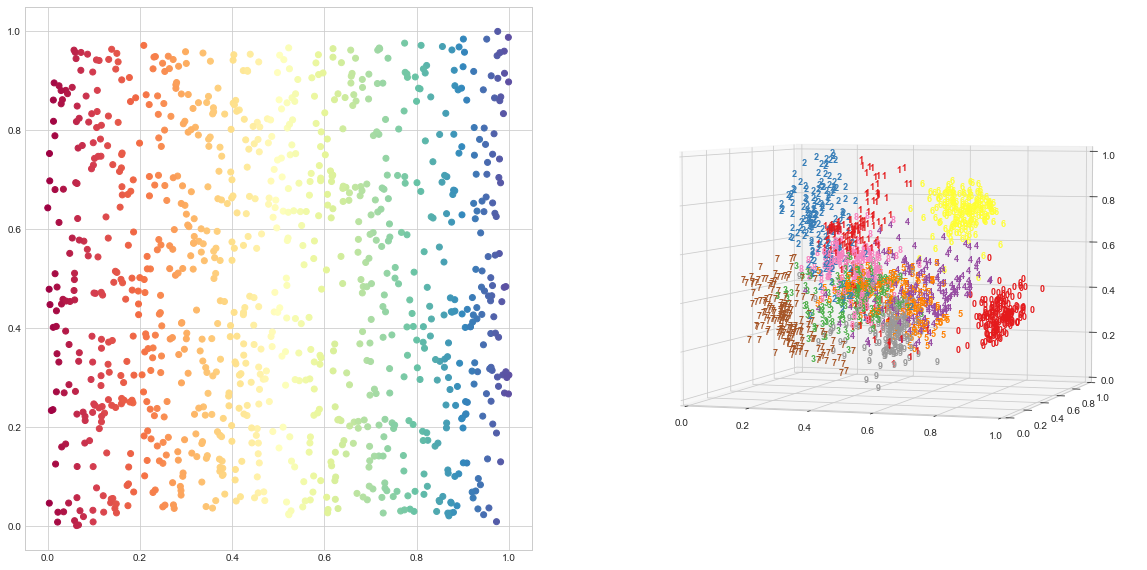

In [18]:
fig = plt.figure(figsize=(20,10))
plot_s_curve(s_curve_isomap, color, 121, '2d')
plot_digits(digits_isomap, labels, 122, '3d')

## Multi-Dimensional Scaling (MDS)

* 고차원 공간에서의 거리를 고려하는 저차원 공간을 찾음

In [19]:
s_curve_mds = manifold.MDS(n_components=2, random_state=0).fit_transform(s_curve)
digits_mds = manifold.MDS(n_components=3, random_state=0).fit_transform(digits)

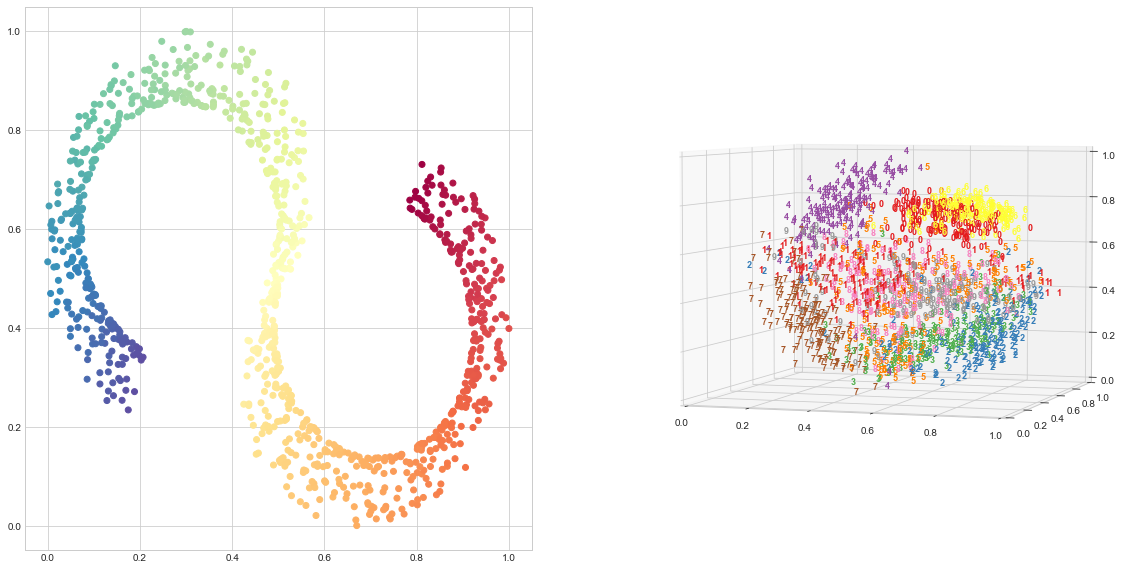

In [20]:
fig = plt.figure(figsize=(20,10))
#3차원데이터를 2차로 변환하여도 거리를고려하다보니 s자 모양유지
plot_s_curve(s_curve_mds, color, 121, '2d')

plot_digits(digits_mds, labels, 122, '3d')

## Spectral Embedding

* 스펙트럼 분해를 통해 데이터의 저차원 표현을 찾음
* 데이터의 점이 저차원 공간에서도 서로 가깝게 유지되도록 함

In [21]:
s_curve_se = manifold.SpectralEmbedding(n_components=2, random_state=0).fit_transform(s_curve)
digits_se = manifold.SpectralEmbedding(n_components=3, random_state=0).fit_transform(digits)

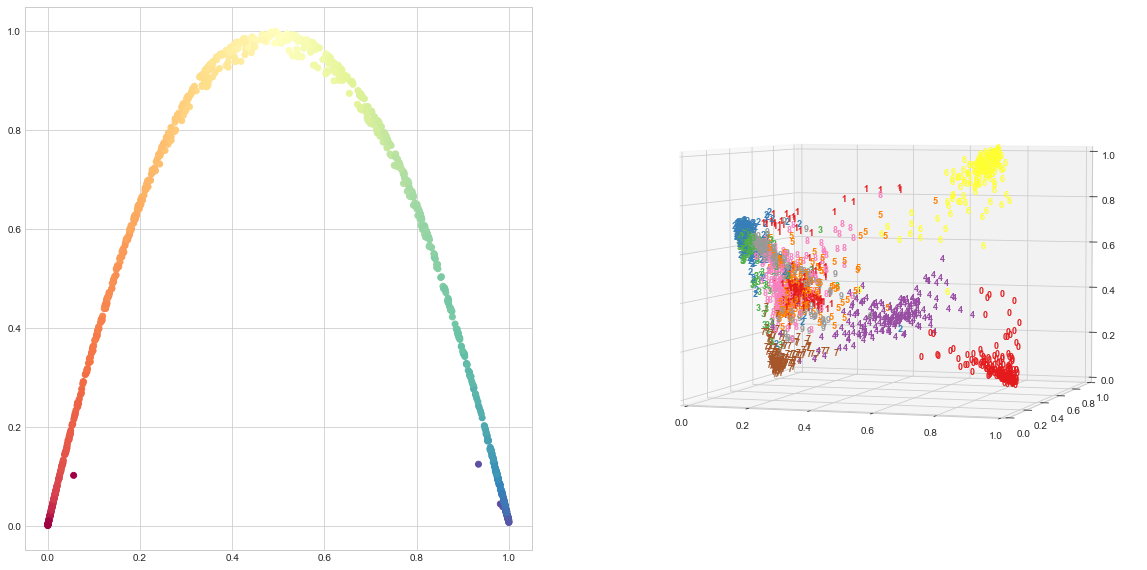

In [22]:
fig = plt.figure(figsize=(20,10))
#3차원데이터를 2차로 변환하여도 거리를고려하다보니 s자 모양유지
plot_s_curve(s_curve_se, color, 121, '2d')

plot_digits(digits_se, labels, 122, '3d')

## t-distributed Stochastic Neighbor Embedding (t-SNE)

* 데이터 포인트의 유사성을 확률로 변환
* 국소 구조에 민감
* 국소 구조를 기반으로 샘플 그룹을 추출하는데 강함
* 항상 KL발산의 국소 최소값에서 끝남
* 계산 비용이 많이 듬
* 전역 구조를 보존하지 않음

In [23]:
s_curve_tsne = manifold.TSNE(n_components=2, random_state=0).fit_transform(s_curve)
digits_tsne = manifold.TSNE(n_components=3, random_state=0).fit_transform(digits)

/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/ps/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


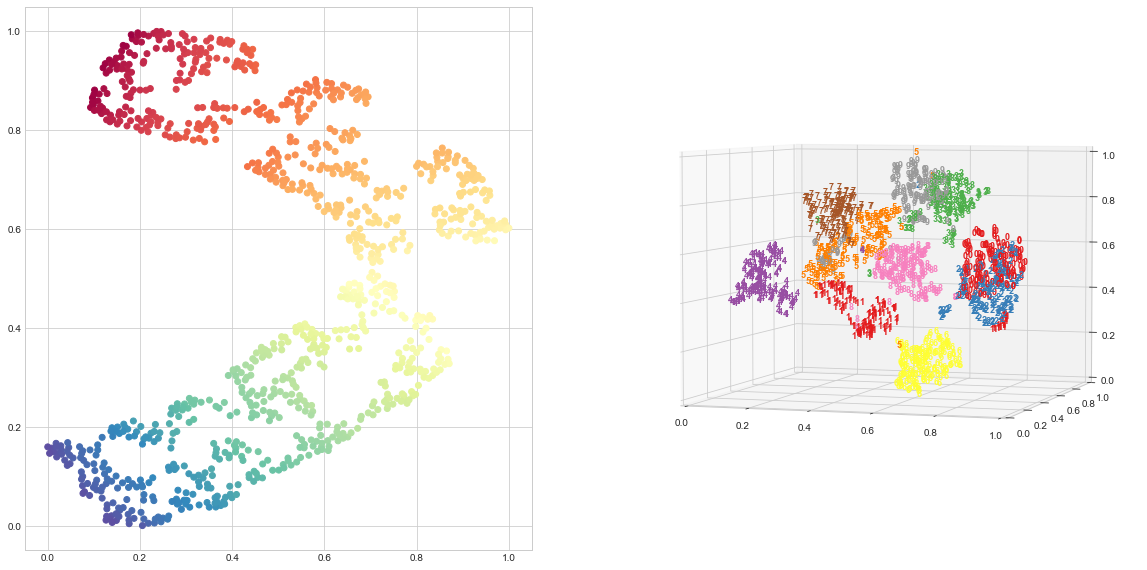

In [24]:
fig = plt.figure(figsize=(20,10))

plot_s_curve(s_curve_tsne, color, 121, '2d')

plot_digits(digits_tsne, labels, 122, '3d')

## 정제된 표현을 이용한 학습
* 다양체 학습의 결과를 정제된 데이터로 생각할 수 있음
* 정제된 표현이기 때문에 분석에 비교적 용이함
* 기계학습 모델의 입력으로 사용했을때 성능향상을 기대할 수 있음

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [26]:
raw_digits, target = datasets.load_digits(return_X_y=True)

In [27]:
knn = KNeighborsClassifier()
svm = SVC()
decision_tree = DecisionTreeClassifier()
random_forest = RandomForestClassifier()

### 원본 데이터를 사용할 때

#### KNN

In [28]:
score = cross_val_score(
    estimator=knn,
    X=raw_digits, y=target,
    cv=5
)
score

array([0.94722222, 0.95555556, 0.96657382, 0.98050139, 0.9637883 ])

In [29]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.9627282575054161 (+/0 0.011168537355954218


#### SVM

In [30]:
score = cross_val_score(
    estimator=svm,
    X=raw_digits, y=target,
    cv=5
)
score

array([0.96111111, 0.94444444, 0.98328691, 0.98885794, 0.93871866])

In [31]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.9632838130609718 (+/0 0.02008605863225686


#### Decision Tree

In [32]:
score = cross_val_score(
    estimator=decision_tree,
    X=raw_digits, y=target,
    cv=5
)
score

array([0.76111111, 0.70555556, 0.80501393, 0.82729805, 0.79108635])

In [33]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.7780129990714949 (+/0 0.0421063744969182


#### Random Forest

In [34]:
score = cross_val_score(
    estimator=random_forest,
    X=raw_digits, y=target,
    cv=5
)
score

array([0.92777778, 0.91944444, 0.9637883 , 0.96100279, 0.92200557])

In [35]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.9388037759207677 (+/0 0.01947079120113876


### 정제된 데이터를 사용할 때

#### KNN

In [36]:
score = cross_val_score(
    estimator=knn,
    X=digits_tsne, y=target,
    cv=5
)
score

array([0.96388889, 0.95833333, 0.98328691, 0.99164345, 0.96935933])

In [37]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.9733023831631075 (+/0 0.01236381496555225


#### SVM

In [38]:
score = cross_val_score(
    estimator=svm,
    X=digits_tsne, y=target,
    cv=5
)
score

array([0.94722222, 0.92777778, 0.98328691, 0.98885794, 0.96100279])

In [39]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.9616295264623955 (+/0 0.022646557006004726


#### Decision Tree

In [40]:
score = cross_val_score(
    estimator=decision_tree,
    X=digits_tsne, y=target,
    cv=5
)
score

array([0.95555556, 0.93611111, 0.98607242, 0.97493036, 0.94150418])

In [41]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.9588347260909934 (+/0 0.019122892974203873


#### Random Forest

In [42]:
score = cross_val_score(
    estimator=random_forest,
    X=digits_tsne, y=target,
    cv=5
)
score

array([0.95833333, 0.91666667, 0.98885794, 0.98885794, 0.96657382])

In [43]:
print('mean cross val score:{} (+/0 {}'.format(score.mean(), score.std()))
      

mean cross val score:0.963857938718663 (+/0 0.026513820595318628
